# Data Fetch and Preparation



In [2]:
!nvidia-smi

Fri Dec 27 17:02:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [5]:
!pip install patchify

In [6]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [7]:
print(tf.__version__)

2.17.0


In [8]:
minmaxscaler = MinMaxScaler()

(6310, 6911)

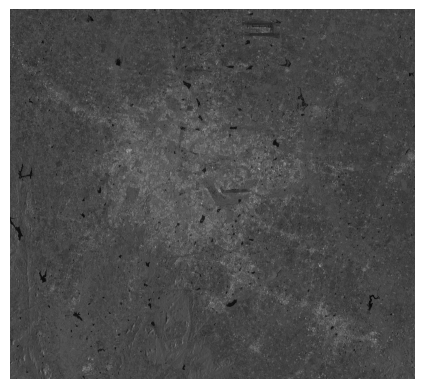

In [9]:
image = cv2.imread('/kaggle/input/sar-data-pspnet/KAT_S1_median_VV_2022_Coregd_Despkl.tif',-1)
# image = cv2.imread(image_path,-1)
plt.imshow(image, 'gray')
plt.axis('off')
image.shape

(6310, 6911)

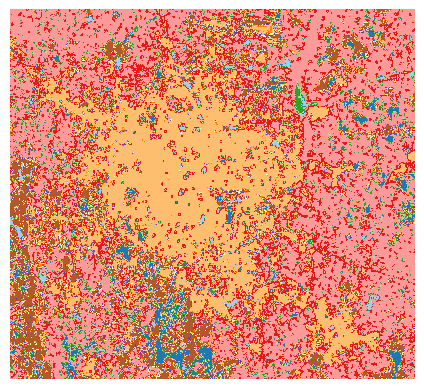

In [10]:
mask = cv2.imread('/kaggle/input/sar-data-pspnet/ESRI_KAT_ROI_2022_Coreg.tif',-1)
plt.imshow(mask,'Paired')
plt.axis('off')
mask.shape

In [11]:
image_patch_size = 128

In [12]:
if image is not None:
    print(image.shape)

    size_x = (image.shape[1] // image_patch_size) * image_patch_size
    size_y = (image.shape[0] // image_patch_size) * image_patch_size
    print(f"{image.shape} --- {size_x} - {size_y}")
    image = Image.fromarray(image).crop((0, 0, size_x, size_y))
    print(f"({image.size[0]},  {image.size[1]})")
    image = np.array(image)

    patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_images.shape)

    # Flatten patched_images array to 2D
    patched_images_flattened = patched_images.reshape(-1, patched_images.shape[2], patched_images.shape[3])
    print(patched_images_flattened.shape)

(6310, 6911)
(6310, 6911) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [13]:
if mask is not None:
    print(mask.shape)

    size_x = (mask.shape[1] // image_patch_size) * image_patch_size
    size_y = (mask.shape[0] // image_patch_size) * image_patch_size
    print(f"{mask.shape} --- {size_x} - {size_y}")
    mask = Image.fromarray(mask).crop((0, 0, size_x, size_y))
    print(f"({mask.size[0]},  {mask.size[1]})")
    mask = np.array(mask)

    patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_masks.shape)

    # Flatten patched_masks array to 2D
    patched_masks_flattened = patched_masks.reshape(-1, patched_masks.shape[2], patched_masks.shape[3])
    print(patched_masks_flattened.shape)

(6310, 6911)
(6310, 6911) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [14]:
image_dataset = np.array(patched_images_flattened)
mask_dataset = np.array(patched_masks_flattened)

(-0.5, 127.5, 127.5, -0.5)

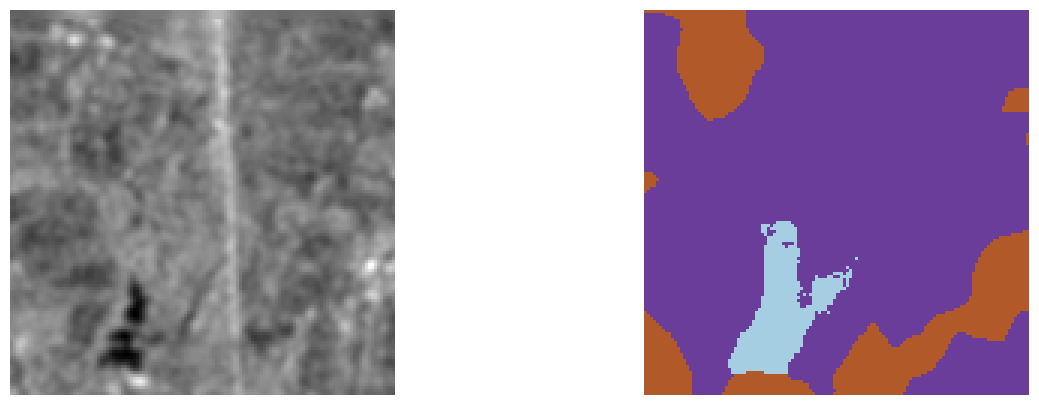

In [15]:
index= 20
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image_dataset[index], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.axis('off')

In [16]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        3: 1,  # Flooded Vegetation becomes Water
        6: 4,  # Bare Ground becomes Crops
        7: 4,  # Snow/Ice becomes Crops
        8: 4,  # Clouds becomes Crops
        9: 4   # Rangeland becomes Crops
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Water
        4: 1,  # Cropland
        2: 3,  # Treecover
        5: 2,  # Builtup
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [17]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (2597, 128, 128)


In [18]:
before_Water = len(np.where(mask_dataset.flatten()==1)[0])
before_Trees =   len(np.where(mask_dataset.flatten()==2)[0])
before_Flooded_Vegetation =   len(np.where(mask_dataset.flatten()==3)[0])
before_Crops =   len(np.where(mask_dataset.flatten()==4)[0])
before_BuiltArea =   len(np.where(mask_dataset.flatten()==5)[0])
before_BareGround =   len(np.where(mask_dataset.flatten()==6)[0])
before_SnowIce =   len(np.where(mask_dataset.flatten()==7)[0])
before_Clouds =   len(np.where(mask_dataset.flatten()==8)[0])
before_Rangeland =   len(np.where(mask_dataset.flatten()==9)[0])

after_Water =   len(np.where(labels_dataset.flatten()==0)[0])
after_Trees =   len(np.where(labels_dataset.flatten()==3)[0])
after_Crops =   len(np.where(labels_dataset.flatten()==1)[0])
after_BuiltArea =   len(np.where(labels_dataset.flatten()==2)[0])

assert (before_Water+before_Flooded_Vegetation) == after_Water, "Water does not match"
assert (before_Crops+before_BareGround+before_SnowIce+before_Clouds+before_Rangeland) == after_Crops, "Crops does not match"
assert before_Trees == after_Trees, "Trees does not match"
assert before_BuiltArea == after_BuiltArea, "BuiltArea does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Trees/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Crops/(labels_dataset.flatten().shape[0]), 3),
                        ' BuiltArea = ', np.round(after_BuiltArea/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [19]:
print(labels_dataset[0].shape)
print(image_dataset[0].shape)

(128, 128)
(128, 128)


In [20]:
np.unique(labels_dataset)

array([0., 1., 2., 3.], dtype=float32)

In [21]:
# index= np.random.choice(image_dataset.shape[0], 1)[0]
# print(index)
# plt.figure(figsize=(15, 5))
# plt.subplot(1,2,1)
# plt.imshow(image_dataset[index], cmap='gray')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(labels_dataset[index],)
# plt.axis('off')

In [22]:
n_classes = 4

In [23]:
# !pip uninstall tensorflow keras -y
# !pip install tensorflow

In [24]:
# print("Shape of psp_output:", tf.keras.backend.int_shape(psp_output))
# print("Shape of conv3:", tf.keras.backend.int_shape(conv3))


In [25]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers.legacy import Adam

# def pspnet_model(input_size=(128, 128, 1), n_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoder (Feature Extraction using Convolutional Layers)
#     conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)

#     conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = layers.MaxPooling2D((2, 2))(conv3)

#     conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = layers.MaxPooling2D((2, 2))(conv4)

#     # Pyramid Pooling Module
#     # def pyramid_pooling_block(input_tensor, bin_sizes):
#     #   pool_outs = [input_tensor]
#     #   input_shape = tf.keras.backend.int_shape(input_tensor)[1:3]  # Get static shape

#     #   for bin_size in bin_sizes:
#     #       # Pooling to the bin size
#     #       x = layers.AveragePooling2D(pool_size=(input_shape[0] // bin_size, input_shape[1] // bin_size),
#     #                                   strides=(input_shape[0] // bin_size, input_shape[1] // bin_size),
#     #                                   padding='same')(input_tensor)
#     #       x = layers.Conv2D(512, (1, 1), activation='relu', padding='same')(x)

#     #       # Upsampling back to the input shape
#     #       x = layers.UpSampling2D(size=(input_shape[0] // bin_size, input_shape[1] // bin_size),
#     #                               interpolation='bilinear')(x)

#     #       # Add the processed feature map to the list
#     #       pool_outs.append(x)

#     #   # Concatenate along the channel axis
#     #   return layers.concatenate(pool_outs, axis=-1)
#     # def pyramid_pooling_block(x, bin_sizes):
#     #   pool_outputs = []
#     #   input_height, input_width = x.shape[1:3]  # Extract spatial dimensions

#     #   for bin_size in bin_sizes:
#     #       pool = layers.AveragePooling2D(
#     #           pool_size=(bin_size, bin_size),
#     #           strides=(bin_size, bin_size),
#     #           padding='same')(x)
#     #       upsample = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(pool)
#     #       upsample = layers.UpSampling2D(
#     #           size=(input_height // pool.shape[1], input_width // pool.shape[2]),
#     #           interpolation='bilinear')(upsample)
#     #       pool_outputs.append(upsample)

#     #   # Ensure all feature maps are concatenated with the same spatial dimensions as x
#     #   pool_outputs.append(x)
#     #   return layers.Concatenate()(pool_outputs)
#     def pyramid_pooling_block(x, bin_sizes):
#         """
#         Pyramid Pooling Module for PSPNet
#         Args:
#             x: Input tensor
#             bin_sizes: List of bin sizes for pooling
#         Returns:
#             Concatenated tensor with global context features
#         """
#         pool_outputs = []
#         input_shape = x.shape[1:3]  # Get height and width of the input tensor
    
#         for bin_size in bin_sizes:
#             # Perform average pooling
#             pool = layers.AveragePooling2D(
#                 pool_size=(bin_size, bin_size),
#                 strides=(bin_size, bin_size),
#                 padding="same"
#             )(x)
    
#             # Convolution to reduce channels
#             conv = layers.Conv2D(64, (1, 1), activation="relu", padding="same")(pool)
    
#             # Resize pooled feature map back to input dimensions
#             upsample = layers.UpSampling2D(
#                 size=(input_shape[0] // bin_size, input_shape[1] // bin_size),
#                 interpolation="bilinear"
#             )(conv)
    
#             pool_outputs.append(upsample)
    
#         # Add the original input tensor to the outputs
#         pool_outputs.append(x)
    
#         # Concatenate all the features
#         return layers.Concatenate()(pool_outputs)






#     psp_output = pyramid_pooling_block(pool4, bin_sizes=[1, 2, 4, 8])

#     # Decoder (Upsampling and Segmentation Output)
#     # Upsample the PSP block output to align with conv3
#     up1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(psp_output)
#     up1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
#     up1 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(up1)  # Align spatially to conv3
#     up1 = layers.concatenate([up1, conv3], axis=-1)

#     # Upsample to align with conv2
#     up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up1)
#     up2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
#     up2 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(up2)  # Align spatially to conv2
#     up2 = layers.concatenate([up2, conv2], axis=-1)

#     # Upsample to align with conv1
#     up3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up2)
#     up3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
#     # No additional upsampling needed for conv1
#     up3 = layers.concatenate([up3, conv1], axis=-1)

#     # Output layer for multi-class segmentation
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(up3)


#     model = models.Model(inputs=[inputs], outputs=[outputs])

#     return model

# # Compile the model for multi-class segmentation
# model = pspnet_model(input_size=(128, 128, 1), n_classes=4)  # 4 classes for segmentation
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Show model summary
# model.summary()


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def pyramid_pooling_block(x, bin_sizes):
    """Pyramid Pooling Module using Keras layers"""
    pool_outputs = []
    h, w = x.shape[1:3]
    
    for bin_size in bin_sizes:
        pool_size = (h // bin_size, w // bin_size)
        pool = AveragePooling2D(pool_size=pool_size, strides=pool_size)(x)
        conv = Conv2D(128, 1, padding='same', activation='relu')(pool)
        up = UpSampling2D(size=pool_size, interpolation='bilinear')(conv)
        pool_outputs.append(up)
    
    return Concatenate()([x] + pool_outputs)

def build_lightweight_pspnet(input_size, n_classes):
    """Build lightweight PSPNet model"""
    inputs = Input(shape=input_size)
    
    # Encoder
    x = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    c1 = MaxPooling2D()(x)
    
    x = Conv2D(128, 3, padding='same', activation='relu')(c1)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    c2 = MaxPooling2D()(x)
    
    x = Conv2D(256, 3, padding='same', activation='relu')(c2)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    c3 = MaxPooling2D()(x)
    
    # Pyramid Pooling Module
    ppm = pyramid_pooling_block(c3, bin_sizes=[1, 2, 4, 8])
    
    # Decoder
    x = Conv2D(256, 3, padding='same', activation='relu')(ppm)
    x = UpSampling2D()(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    
    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
    
    return Model(inputs, outputs)

# Usage
input_shape = (128, 128, 1)
n_classes = 4
# model = build_lightweight_pspnet(input_shape, n_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
X = image_dataset[..., np.newaxis]  # Add channel dimension
y = to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = (128, 128, 1)
n_classes = 4
model = build_lightweight_pspnet(input_shape, n_classes)

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    # verbose=12,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    # class_weight=class_weights,
                    callbacks=[callback])
# print("Shape of up2 before concatenation:", tf.keras.backend.int_shape(up2))
# print("Shape of conv2:", tf.keras.backend.int_shape(conv2))


Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 589ms/step - accuracy: 0.4811 - loss: 1.1599 - val_accuracy: 0.5819 - val_loss: 0.9865 - learning_rate: 0.0010
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.6663 - loss: 0.8960 - val_accuracy: 0.7629 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.7123 - loss: 0.8102 - val_accuracy: 0.7539 - val_loss: 0.7093 - learning_rate: 0.0010
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.7564 - loss: 0.6871 - val_accuracy: 0.7775 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.7819 - loss: 0.6205 - val_accuracy: 0.7834 - val_loss: 0.6122 - learning_rate: 0.0010
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.7901 - loss: 0.5919 - val_accuracy: 0.7781 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.7835 - loss: 0.5976 -

In [77]:
model.save("pspnet.keras")

In [28]:
# !pip install tensorflow==2.10 keras segmentation-models

In [29]:
# import tensorflow as tf
# import numpy as np
# from segmentation_models import PSPNet

# base_path = '/content/drive/My Drive/Colab Notebooks/sar_pe/2022_Data'


# # Specify the paths to your calibrated model and training history
# # model_path = '<Model_Name>.keras'
# # history_path = '<Model_history>.npy'
# model_path = os.path.join(base_path, 'Model_Name.keras')
# history_path = os.path.join(base_path, 'Model_history.npy')

# # Load the training history
# history = np.load(history_path, allow_pickle=True).item()
# print("Training history loaded successfully.")

# # Load the PSPNet model
# model = tf.keras.models.load_model(model_path, compile=False)  # Use compile=False if loading a pretrained model
# print("Model loaded successfully.")
# model.summary()

# # (Optional) Continue training or fine-tuning the model
# # Example: Compile the model if needed
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.models as models

# class PSPModule(nn.Module):
#     def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
#         super().__init__()
#         self.stages = []
#         self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
#         self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
#         self.relu = nn.ReLU()

#     def _make_stage(self, features, size):
#         prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
#         conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
#         return nn.Sequential(prior, conv)

#     def forward(self, feats):
#         h, w = feats.size(2), feats.size(3)
#         priors = [F.interpolate(input=stage(feats), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages]
#         priors.append(feats)
#         bottle = self.bottleneck(torch.cat(priors, 1))
#         return self.relu(bottle)

# class PSPNet(nn.Module):
#     def __init__(self, n_classes=2, sizes=(1, 2, 3, 6)):
#         super().__init__()
#         self.resnet = models.resnet50(pretrained=True)
#         self.layer0 = nn.Sequential(
#             self.resnet.conv1,
#             self.resnet.bn1,
#             self.resnet.relu,
#             self.resnet.maxpool
#         )
#         self.layer1 = self.resnet.layer1
#         self.layer2 = self.resnet.layer2
#         self.layer3 = self.resnet.layer3
#         self.layer4 = self.resnet.layer4

#         self.psp = PSPModule(2048, 1024, sizes)
#         self.drop_1 = nn.Dropout2d(p=0.3)
#         self.final = nn.Sequential(
#             nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Dropout2d(p=0.1),
#             nn.Conv2d(256, n_classes, kernel_size=1)
#         )

#     def forward(self, x):
#         input_size = (x.size()[2], x.size()[3])
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.psp(x)
#         x = self.drop_1(x)
#         x = self.final(x)
#         return F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

#     # def predict(model, image_dataset):
#     #   model.eval()
#     #   with torch.no_grad():
#     #       # Reshape input to [batch_size, channels=3, height, width]
#     #       if isinstance(image_dataset, np.ndarray):
#     #           image_dataset = torch.from_numpy(image_dataset)

#     #       # If input is [height, width], expand to [1, 3, height, width]
#     #       if len(image_dataset.shape) == 2:
#     #           image_dataset = image_dataset.unsqueeze(0).repeat(3, 1, 1)
#     #           image_dataset = image_dataset.unsqueeze(0)

#     #       # If input is [batch, height, width], expand to [batch, 3, height, width]
#     #       elif len(image_dataset.shape) == 3:
#     #           image_dataset = image_dataset.unsqueeze(1).repeat(1, 3, 1, 1)

#     #       image_dataset = image_dataset.float()
#     #       image_dataset = image_dataset.to(next(model.parameters()).device)

#     #       predictions = model(image_dataset)
#     #       return predictions.cpu().numpy()
# def predict(model, image_dataset, batch_size=32):
#     """
#     Perform batch predictions using a PyTorch model on a NumPy dataset.

#     Args:
#         model (torch.nn.Module): The trained PyTorch model for inference.
#         image_dataset (np.ndarray): Input dataset as a NumPy array, shape [N, C, H, W].
#         batch_size (int): Number of samples per batch.

#     Returns:
#         np.ndarray: Combined predictions for the entire dataset.
#     """
#     model.eval()  # Set the model to evaluation mode
#     all_predictions = []

#     with torch.no_grad():  # Disable gradient computation for inference
#         for i in range(0, len(image_dataset), batch_size):
#             # Extract a batch from the NumPy array
#             batch = image_dataset[i:i + batch_size]
#             batch_tensor = torch.from_numpy(batch).float()  # Convert to PyTorch tensor

#             # Ensure the input tensor has 3 channels (e.g., RGB images)
#             if batch_tensor.shape[1] != 3:
#                 batch_tensor = batch_tensor.unsqueeze(1).repeat(1, 3, 1, 1)

#             # Move the batch to the device (GPU or CPU)
#             batch_tensor = batch_tensor.to(next(model.parameters()).device)

#             # Forward pass through the model
#             predictions = model(batch_tensor)

#             # Convert predictions to NumPy and append to the results list
#             all_predictions.append(predictions.cpu().numpy())

#     # Combine all predictions from batches into a single array
#     full_predictions = np.concatenate(all_predictions, axis=0)
#     return full_predictions


# # # Usage
# # full_map_predictions = predict(model, image_dataset)
# # print(full_map_predictions.shape)
# # full_map_reshape = np.argmax(full_map_predictions, axis=1).flatten()  # Changed axis from -1 to 1

# # Usage example
# def train_model(model, train_loader, criterion, optimizer, device):
#     model.train()
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

# def process_sar_image(image_path):
#     # Load and preprocess SAR image
#     import cv2
#     import numpy as np

#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
#     image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
#     return image

# # Model initialization
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = PSPNet(n_classes=2).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# import numpy as np
# from tensorflow.keras.models import load_model

# # Plug Calibrated PSPNet Model
# # Replace '<Model_Name>' with the actual file path to your saved PSPNet model
# model = load_model('<Model_Name>.keras')
# model.summary()

# # Load training history
# # Replace '<Model_history>' with the actual file path to your saved history
# history = np.load('<Model_history>.npy', allow_pickle=True).item()

# # Accessing the history dictionary
# print("Training history keys:", history.keys())

# # Example: Plotting training and validation accuracy
# import matplotlib.pyplot as plt

# plt.plot(history['accuracy'], label='Train Accuracy')
# plt.plot(history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


In [32]:
###Plug Calibrated Model load here
# history=np.load('<Model_history>.npy',allow_pickle='TRUE').item()
# model = tf.keras.models.load_model('<Model_Name>.keras')
# model.summary()

In [33]:
# plt.plot(history['loss'], label = 'Training loss')
# plt.plot(history['val_loss'], label = 'Validation loss')
# plt.title('Model Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend()

In [34]:
# plt.plot(history['val_tn'],label='True Negatives')
# plt.plot(history['val_fn'],label='False Negatives')
# plt.plot(history['val_tp'],label='True Positive')
# plt.plot(history['val_fp'],label='False Positives')
# plt.title('Model Predictions')
# plt.ylabel('prediction')
# plt.xlabel('epoch')
# plt.legend()

In [35]:
# plt.plot(history['val_precision_0'],label='Water')
# plt.plot(history['val_precision_1'],label='Bareland')
# plt.plot(history['val_precision_2'],label='Builtup')
# plt.plot(history['val_precision_3'],label='Treecover')
# plt.title('Variation of Precision with epoch')
# plt.ylabel('Precision')
# plt.xlabel('epoch')
# plt.legend()

In [36]:
# plt.plot(history['val_recall_0'],label='Water')
# plt.plot(history['val_recall_1'],label='Bareland')
# plt.plot(history['val_recall_2'],label='Builtup')
# plt.plot(history['val_recall_3'],label='Treecover')
# plt.title('Variation of Precision with epoch')
# plt.ylabel('Recall')
# plt.xlabel('epoch')
# plt.legend()

In [37]:
code_label ={'Water':0, 'Bareland':1, 'Builtup':2, 'Treecover':3}

In [38]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Trees =   len(np.where(flat_pixels==code_label['Treecover'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Trees = ', np.round(after_Trees/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' BuiltArea = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [57]:
# def convert_to_rgb(masks):
#   colour_dict={
#     code_label['Water']:[0, 100, 200], #blue
#     code_label['Bareland']:[240, 150, 255], #pink
#     code_label['Builtup']:[250, 0, 0],  #red
#     code_label['Treecover']:[0, 100, 0] #green
#   }
#   try:
#     return np.array(list(map(lambda x : colour_dict[x], masks)))
#   except:
#     return np.array(list(map(lambda x : convert_to_rgb(x), masks)))

def convert_to_rgb(masks):
    colour_dict = {
        code_label['Water']: [0, 100, 200],      # blue
        code_label['Bareland']: [240, 150, 255], # pink 
        code_label['Builtup']: [250, 0, 0],      # red
        code_label['Treecover']: [0, 100, 0]     # green
    }
    
    # Reshape to 2D if needed
    original_shape = masks.shape
    flat_masks = masks.reshape(-1)
    
    # Convert to RGB
    rgb_array = np.array([colour_dict[int(x)] for x in flat_masks])
    
    # Restore original dimensions + RGB
    return rgb_array.reshape(original_shape + (3,))

In [40]:
def unpatchify(patches, output_shape):
    if len(patches.shape) >3:
        num_patches, patch_height, patch_width, num_channel = patches.shape
    else:
        num_patches, patch_height, patch_width = patches.shape
        num_channel =1
    output_height, output_width = output_shape

    # Compute the number of patches along the height and width of the output image
    num_patches_h = output_height // patch_height
    num_patches_w = output_width // patch_width

    # Reshape patches into a grid
    patches_grid = patches.reshape(num_patches_h, num_patches_w, patch_height, patch_width,num_channel )

    # Concatenate patches along the height axis
    image_rows = [np.concatenate(patches_grid[i], axis=1) for i in range(num_patches_h)]

    # Concatenate rows along the width axis to reconstruct the image
    reconstructed_image = np.concatenate(image_rows, axis=0)

    return reconstructed_image

In [41]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [62]:
full_map_predictions = model.predict(image_dataset)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
(2597, 128, 128, 4)


In [44]:
type(image_dataset)

numpy.ndarray

In [45]:
print(image_dataset.shape)
print("Ground truth shape:", labels_dataset.shape)
print("Predictions shape:", full_map_predictions.shape)

full_map_reshape = np.argmax(full_map_predictions, axis=1)
print("Reshaped predictions shape:", full_map_reshape.shape)  # Should be (2597, 128, 128)

(2597, 128, 128)
Ground truth shape: (2597, 128, 128)
Predictions shape: (2597, 128, 128, 4)
Reshaped predictions shape: (2597, 128, 4)


In [46]:
# conf_matrix=confusion_matrix(labels_dataset.flatten(), full_map_reshape)
# conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# conf_matrix = np.round(conf_matrix, decimals=2)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(code_label.keys()), yticklabels=list(code_label.keys()))
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()

In [49]:
print("Labels shape:", labels_dataset.shape)
print("Predictions shape:", full_map_reshape.shape)
predictions_flattened = full_map_reshape.flatten()
labels_flattened = labels_dataset.flatten()  # Convert to numpy if it's a tensor

# Verify shapes again
print("Flattened shapes:", labels_flattened.shape, predictions_flattened.shape)

Labels shape: (2597, 128, 128)
Predictions shape: (2597, 128, 4)
Flattened shapes: (42549248,) (1329664,)


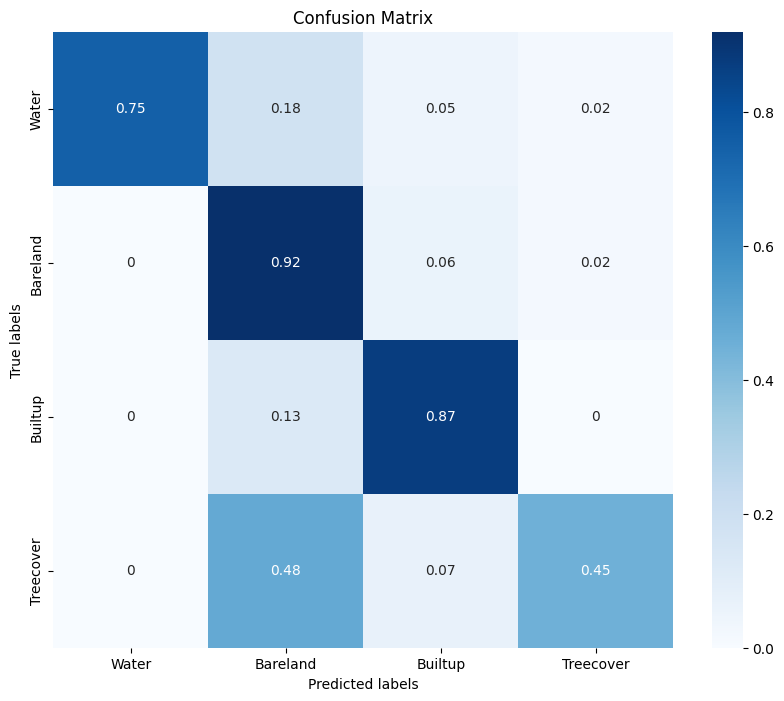

In [63]:
conf_matrix=confusion_matrix(labels_dataset.flatten(), full_map_reshape)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = np.round(conf_matrix, decimals=2)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(code_label.keys()), yticklabels=list(code_label.keys()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [64]:
report=classification_report(labels_dataset.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Water,0.862998,0.746051,0.800275,9.218360e+05
Bareland,0.849037,0.917416,0.881903,2.229441e+07
Builtup,0.902912,0.865779,0.883956,1.655157e+07
Treecover,0.702729,0.452629,0.550610,2.781426e+06
accuracy,0.863234,0.863234,0.863234,8.632338e-01
macro avg,0.829419,0.745469,0.779186,4.254925e+07
weighted avg,0.860733,0.863234,0.859277,4.254925e+07


In [66]:
pd.DataFrame.from_dict( compute_class_wise_iou(labels_dataset.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Water,0.667048
Bareland,0.788754
Builtup,0.792044
Treecover,0.379890
mean_iou,0.656934
weighted_iou,0.760670


In [67]:
print('Full Map Predictions : ')
count_class(full_map_reshape, code_label)
print('Full map true labels : ')
count_class(labels_dataset.flatten(), code_label)

Full Map Predictions : 
 Water =  0.019  Trees =  0.042  Bareland =  0.566  BuiltArea =  0.373
Full map true labels : 
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [68]:
full_map_pred_colour=convert_to_rgb(np.argmax(full_map_predictions, axis=-1))
full_map_test_colour=convert_to_rgb(labels_dataset)

In [70]:
print(full_map_pred_colour.shape)
print(full_map_test_colour.shape)
print(image_dataset.shape)

(2597, 128, 128, 3)
(2597, 128, 128, 3)
(2597, 128, 128)


Original image shape: (6272, 6784)
Number of patches: height=49, width=53
Reconstruction dimensions: (6272, 6784)


(-0.5, 6783.5, 6271.5, -0.5)

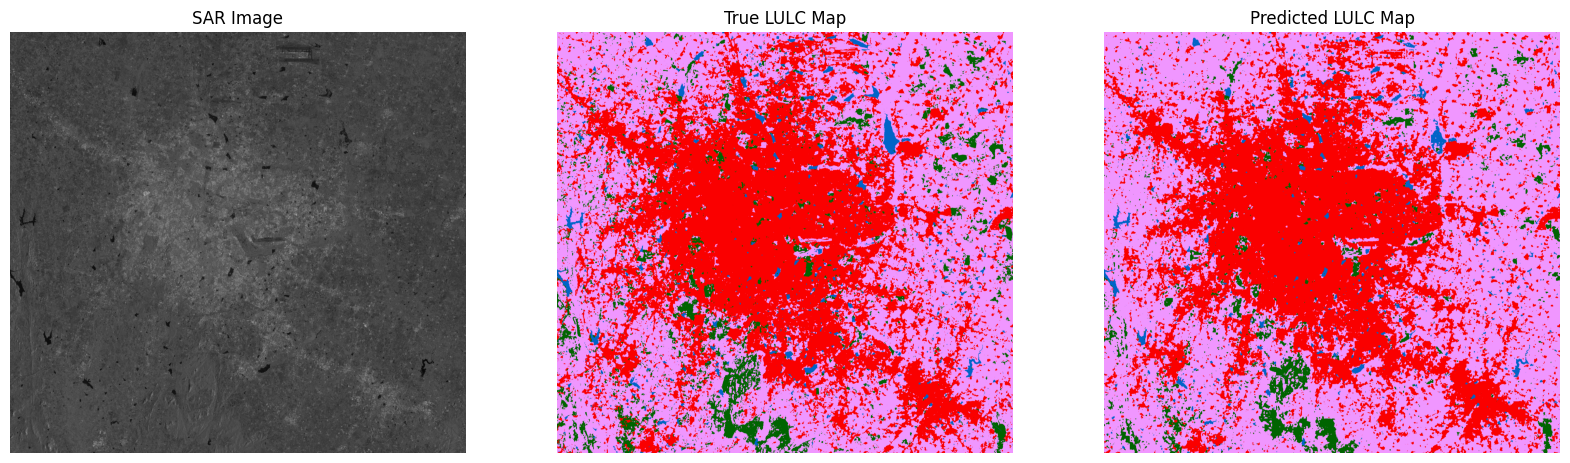

In [71]:
# Calculate correct dimensions
patch_size = 128
h, w = image.shape
n_h = h // patch_size
n_w = w // patch_size
reconstructed_height = n_h * patch_size
reconstructed_width = n_w * patch_size

print(f"Original image shape: {image.shape}")
print(f"Number of patches: height={n_h}, width={n_w}")
print(f"Reconstruction dimensions: ({reconstructed_height}, {reconstructed_width})")

plt.figure(figsize=(20, 25))

# Use the calculated dimensions
reconstructed_image = unpatchify(image_dataset, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('SAR Image')
plt.axis('off')

reconstructed_image = unpatchify(full_map_test_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image)
plt.title('True LULC Map')
plt.axis('off')

reconstructed_image = unpatchify(full_map_pred_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title('Predicted LULC Map')
plt.axis('off')

In [72]:
per_sample_accuracy=[]
full_map_pred_argmax = np.argmax(full_map_predictions, axis=-1)
for i in range(full_map_pred_argmax.shape[0]):
    per_sample_accuracy.append(np.mean(full_map_pred_argmax[i].flatten() == labels_dataset[i].flatten()))


In [73]:
lower10mark = np.percentile(per_sample_accuracy, 10)
upper10mark = np.percentile(per_sample_accuracy, 90)

In [74]:
lower10_y_pred=[]
upper10_y_pred=[]
lower10_y_test=[]
upper10_y_test=[]
lower10_x_test=[]
upper10_x_test=[]
for i in range(len(per_sample_accuracy)):
    if(per_sample_accuracy[i]<=lower10mark):
        lower10_y_pred.append(full_map_pred_colour[i])
        lower10_y_test.append(full_map_test_colour[i])
        lower10_x_test.append(labels_dataset[i])
    elif(per_sample_accuracy[i]>=upper10mark):
        upper10_y_pred.append(full_map_pred_colour[i])
        upper10_y_test.append(full_map_test_colour[i])
        upper10_x_test.append(labels_dataset[i])

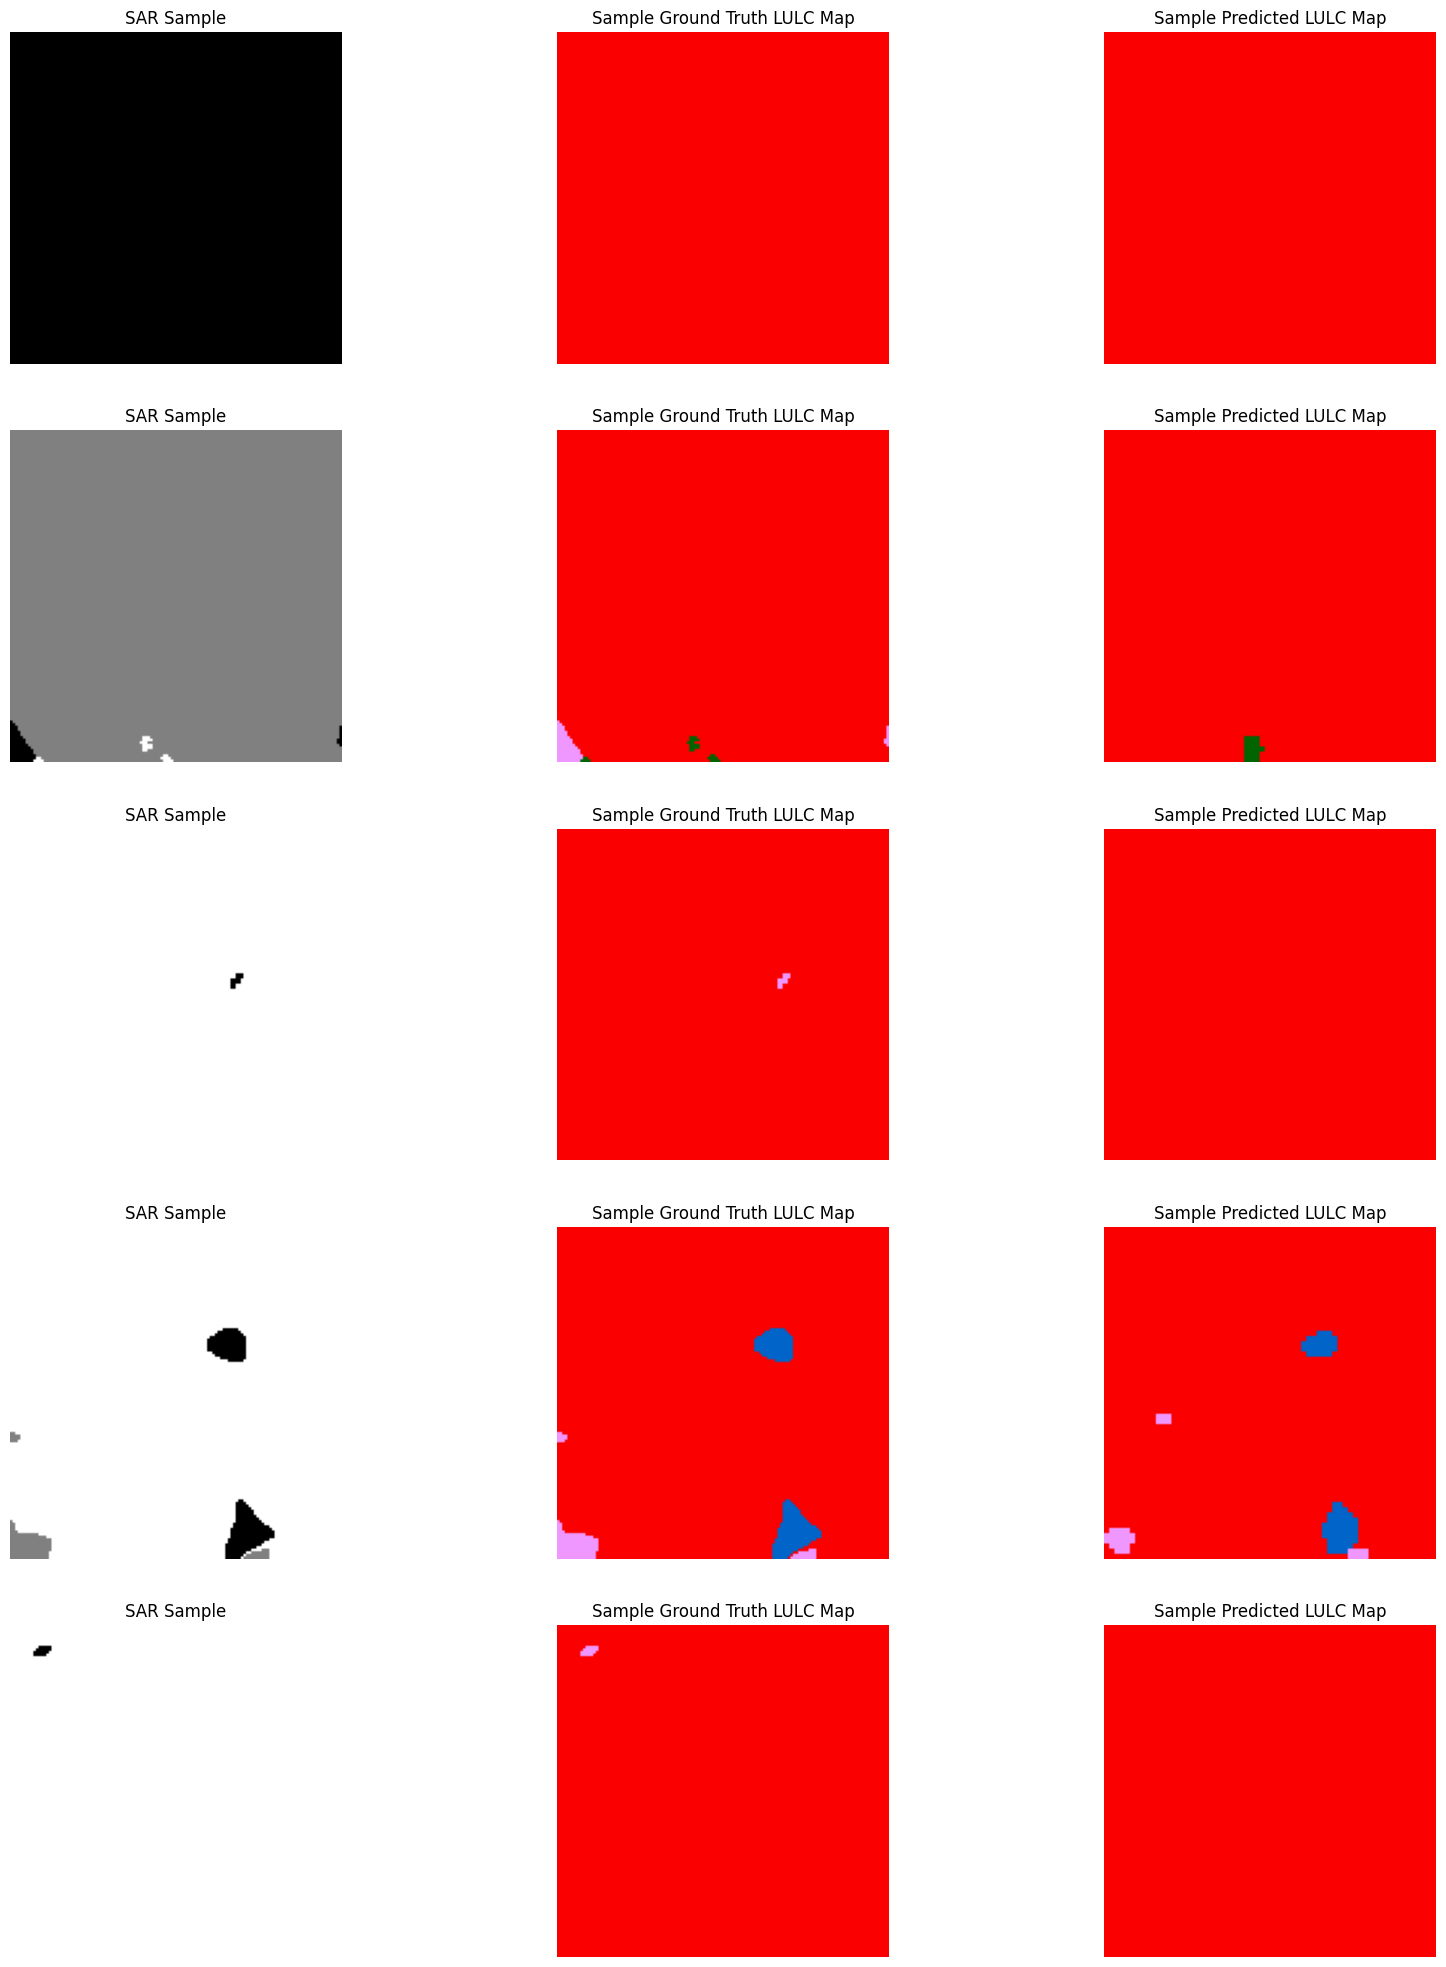

In [75]:
n_images=5
sample_index = np.random.choice(len(upper10_y_pred), n_images)
plt.figure(figsize=(20, 10*n_images/2))
for j,i in enumerate(sample_index):
    pred= upper10_y_pred[i]
    true= upper10_y_test[i]
    sar= upper10_x_test[i]
    plt.subplot(n_images, 3,(j*3)+1)
    plt.imshow(sar,cmap = 'gray')
    plt.title('SAR Sample')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+2)
    plt.imshow(true)
    plt.title('Sample Ground Truth LULC Map')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+3)
    plt.imshow(pred)
    plt.title('Sample Predicted LULC Map')
    plt.axis('off')